# **Processing .nrrd Dataset**

In previous notebooks, we obtained **.nrrd** representations of pre-op and post-op CT scans. However, during the **pre-op scan**, a soft **stabilizing brace** was used to support the tibial plateau fracture.  

This brace contains various materials—**fabric, Velcro straps, and a plastic zipper**—which have **Hounsfield Unit (HU) values overlapping** with those found in the patient’s anatomy (**soft tissue, cartilage, bone, and skin**).  

Since simple thresholding cannot differentiate between the brace and the knee, this notebook focuses on **segmenting the knee joint** and **removing the brace artifacts** from the dataset.  


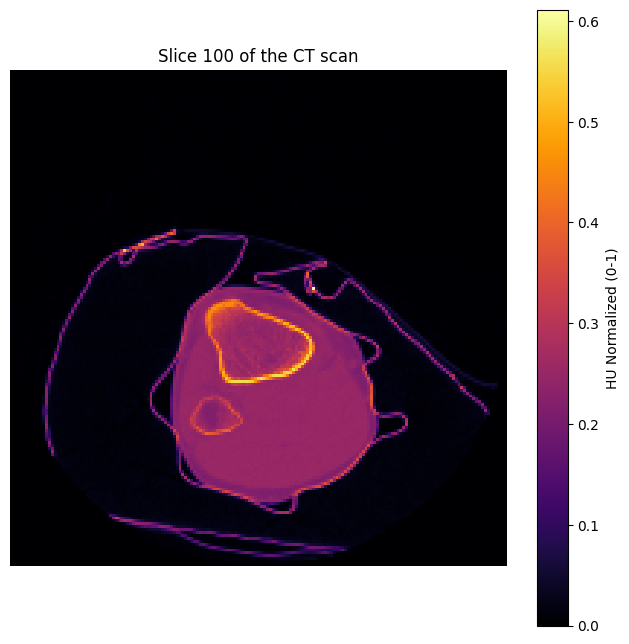

In [25]:
%reset -f
import nrrd 
import matplotlib.pyplot as plt

filename = "data/ct_scan_knee_preop.nrrd"
data, header = nrrd.read(filename)

# Select a slice
slice_index = 100
slice_data = data[slice_index] 

# Plot the slice
plt.figure(figsize=(8, 8))
plt.imshow(slice_data, cmap='inferno', interpolation='none')
plt.title(f'Slice {slice_index} of the CT scan')
plt.colorbar(label='HU Normalized (0-1)')
plt.axis('off')  # Hide axis
plt.show()

In [26]:
# Helper function
def plot_comparison(images, titles, cmap="inferno", color_bar=False):
    """
    Plots multiple images side by side for comparison.

    Parameters:
    - images (list of numpy.ndarray): List of images to display.
    - titles (list of str): List of titles corresponding to each image.
    - cmap (str): Color map to use for displaying images (default: "inferno").
    """
    assert len(images) == len(titles), "Number of images and titles must match for correct labeling."

    fig, ax = plt.subplots(1, len(images), figsize=(6 * len(images), 6))

    if len(images) == 1:
        ax = [ax]  # Ensure ax is iterable for a single image

    for i, (image, title) in enumerate(zip(images, titles)):
        ax[i].imshow(image, cmap=cmap, interpolation='none')
        ax[i].set_title(title)
        ax[i].axis("off")  # Hide axes for better visualization
        if(color_bar):
            plt.colorbar(ax[i].imshow(image, cmap=cmap, interpolation='none'), ax=ax[i], orientation='vertical')

    plt.show()

print(slice_data.dtype)  # Check data type (e.g., float32, int16, etc.)
print(slice_data.shape)  # Shape of the selected slice


float32
(171, 171)


## Attempt 1: Morphological Opening Approach  

Let's start with a simple technique for removing artifacts: **morphological opening**, which consists of **erosion** followed by **dilation**. This method is useful for removing thin or scattered structures, such as those from the stabilizing brace, while preserving the overall shape of larger anatomical features like the knee.  

### Erosion: Shrinking Small Structures  

Erosion examines each pixel and replaces it with the **minimum value** of its surrounding pixels within a defined kernel. This causes bright regions to shrink, effectively breaking apart thin connections and removing small, isolated structures.  

In the context of our CT scan, erosion specifically targets and helps eliminate the thin fabric elements of the brace by reducing their presence in the binary mask. However, it will also shrink the boundary of the knee.  

### Dilation: Restoring the Main Structure  

Dilation is the inverse of erosion—it replaces each pixel with the **maximum value** of its surrounding pixels within the kernel. This expands bright regions, helping to restore the knee's original appearance that may have been reduced during erosion.  

In our case, dilation allows the knee to regain its original shape but doesn't restore the parts that have been deleted by the erosion. The key is selecting appropriate kernel sizes for both erosion and dilation to ensure that the brace is effectively removed while the knee remains intact.  

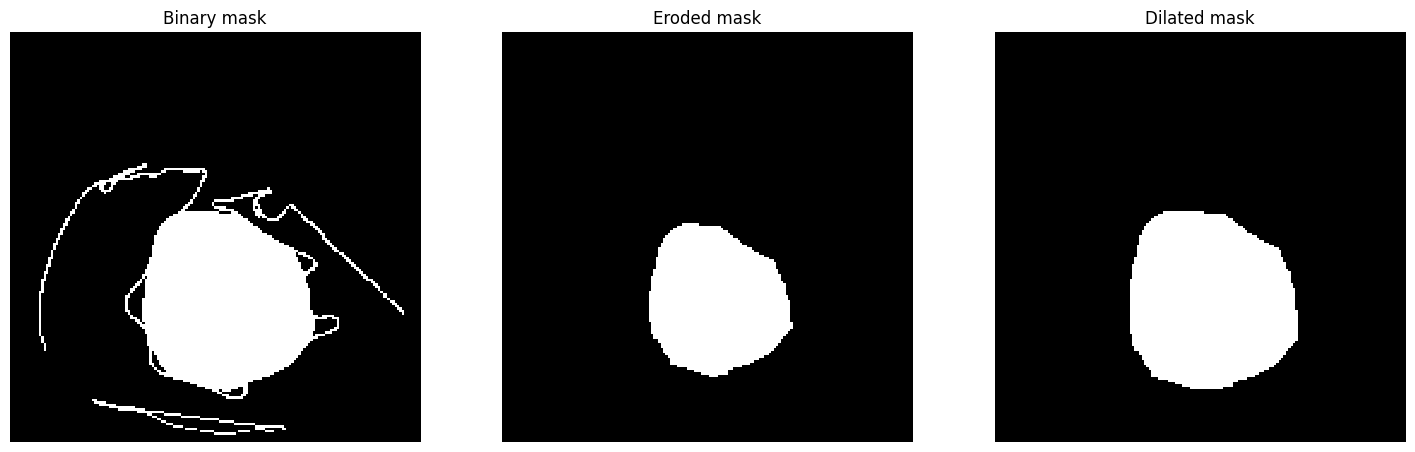

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create a binary mask from the CT slice
threshold = 0.1
binary_mask = (slice_data > threshold).astype(np.uint8)  # Convert to 0 and 1

# Apply erosion
erosion_kernel_size = 11
erosion_kernel = np.ones((erosion_kernel_size, erosion_kernel_size), np.uint8)
eroded_mask = cv2.erode(binary_mask, erosion_kernel, iterations=1)

# Apply dilation
dilation_kernel_size = 11
dilation_kernel = np.ones((dilation_kernel_size, dilation_kernel_size), np.uint8)
dilated_mask = cv2.dilate(eroded_mask, dilation_kernel, iterations=1)

plot_comparison((binary_mask, eroded_mask, dilated_mask), ("Binary mask", "Eroded mask", "Dilated mask"), cmap="grey")

## Using the Mask to Remove the Knee Brace

By multiplying the original image with the mask, we can remove the brace while preserving the knee joint's structure.

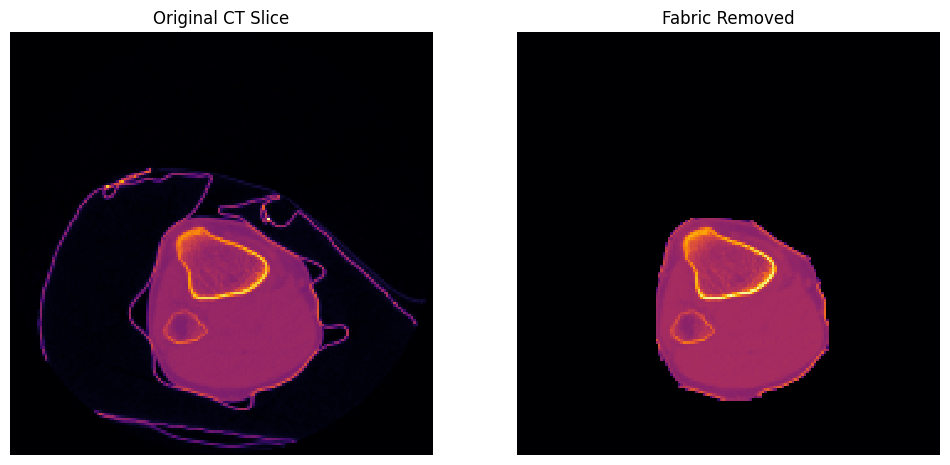

In [28]:
# Apply mask to remove unwanted fabric
cleaned_slice = slice_data * dilated_mask  # Zero out unwanted areas

plot_comparison((slice_data, cleaned_slice), ("Original CT Slice", "Fabric Removed"))

## Solving blockyness

At first I used a built-in method from opencv2 that combines the erosion and dilation into one function **with the same kernel size**:

``morphologyEx(slice_data, cv2.MORPH_OPEN, kernel)``

However, when exporting this data, I noticed that the surface of the knee became very blocky. This can be attributed to two reasons:
- Binary mask: The cells on the surface that were previously partially filled with "knee" data are set to 0 or 1 in the mask. This information is lost and causes blockiness.
-  Morphological operations in general. An erosion operation, for example, examines all the cells in the kernel and sets the value to the minimum one. In a cell where an edge is present, the new value will just become 0.

Both reasons ultimately stem from the fact that the boundary of the mask overlaps with the surface of the knee, which means that data in this region will always be altered.

### Solution 1 (Ineffective)

Initially, I considered the solution to be post-processing the blocky mask. While this helps somewhat, it merely smooths over the blockiness. Instead of distinct steps in the surface of the knee joint, you now have smoothed-over steps in the surface.

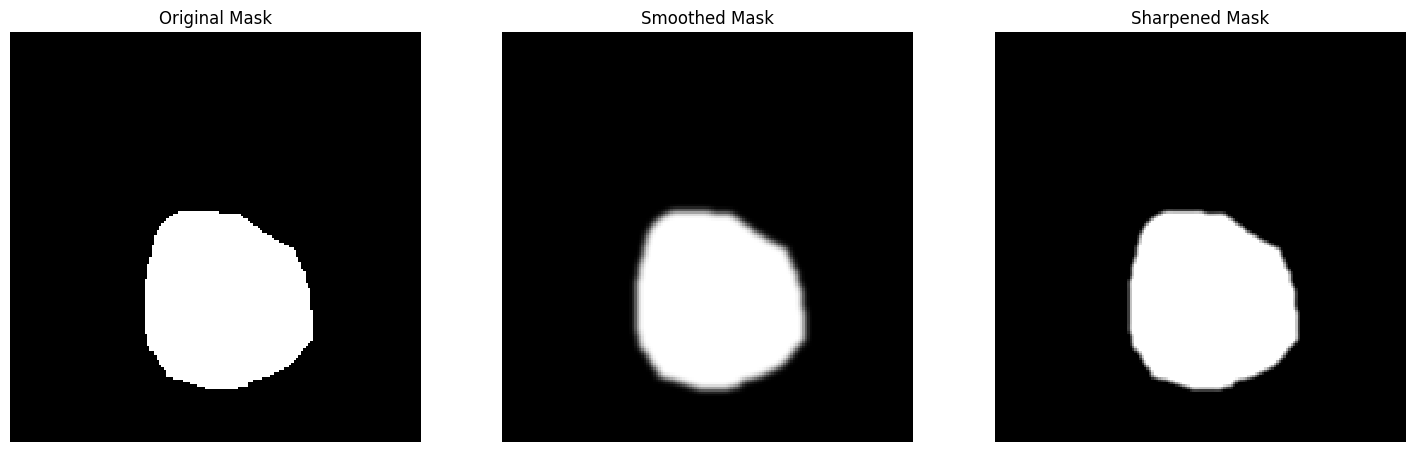

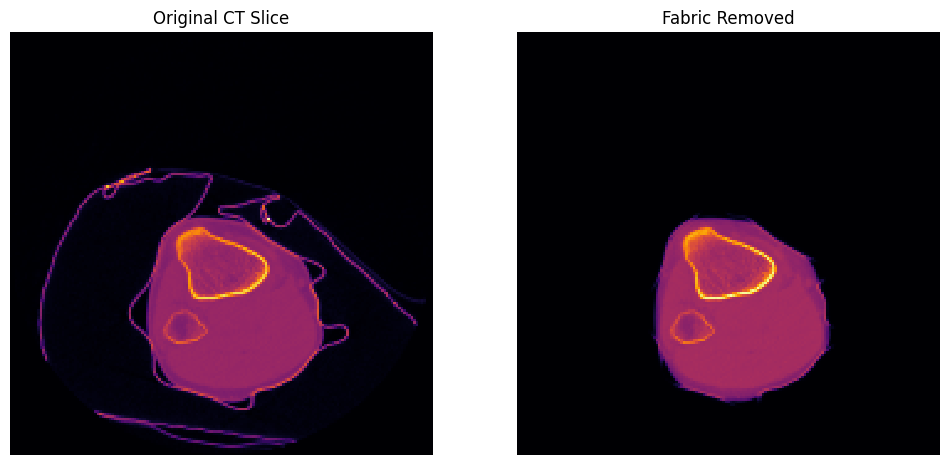

In [33]:
# Apply Gaussian blur to smooth the mask
smoothed_mask = cv2.GaussianBlur(dilated_mask.astype(np.float32), (7, 7), 0)

# Apply Laplacian to enhance edges
laplacian = cv2.Laplacian(smoothed_mask, cv2.CV_32F, ksize=3)

# Sharpen by subtracting Laplacian from the smoothed mask
sharpened_mask = np.clip(smoothed_mask - 0.5 * laplacian, 0, 1)

# Plot the original mask vs. smoothed mask vs. sharpened mask
plot_comparison((dilated_mask, smoothed_mask, sharpened_mask), ("Original Mask", "Smoothed Mask", "Sharpened Mask"), cmap='grey')

# Apply mask to remove unwanted fabric
cleaned_slice = slice_data * smoothed_mask  # Zero out unwanted areas

plot_comparison((slice_data, cleaned_slice), ("Original CT Slice", "Fabric Removed"))


### Solution 2: Splitting up the Dilation and Erosion Steps

By splitting up the steps, we can control the erosion and dilation kernel sizes separately. By choosing a larger kernel for the dilation step, we effectively ensure that the mask "hovers" over the surface of the knee joint. This means none of the original surface is altered in any way. 
We will now apply this concept to all data and verify that the result is effective.


In [ ]:
def remove_fabric_artifacts(data, erosion_kernel_size, dilation_kernel_size, threshold=0.1):
    """
    Applies erosion followed by dilation to remove fabric artifacts from a CT scan.

    Parameters:
    - data (numpy.ndarray): 3D CT scan volume.
    - erosion_kernel_size (int): Size of the erosion kernel.
    - dilation_kernel_size (int): Size of the dilation kernel.
    - threshold (float): Threshold for binary mask.

    Returns:
    - cleaned_data (numpy.ndarray): CT scan with fabric artifacts removed.
    """
    
    cleaned_data = np.copy(data)  # Copy to avoid modifying original

    # Define kernels
    erosion_kernel = np.ones((erosion_kernel_size, erosion_kernel_size), np.uint8)
    dilation_kernel = np.ones((dilation_kernel_size, dilation_kernel_size), np.uint8)

    # Iterate over each slice
    for i in range(data.shape[0]):
        slice_data = data[i]

        # Create a binary mask
        binary_mask = (slice_data > threshold).astype(np.uint8)

        # Apply erosion
        eroded_mask = cv2.erode(binary_mask, erosion_kernel, iterations=1)

        # Apply dilation
        dilated_mask = cv2.dilate(eroded_mask, dilation_kernel, iterations=1)

        # Apply mask to remove fabric
        cleaned_data[i] = slice_data * dilated_mask  # Zero out unwanted areas

    return cleaned_data

# Remove fabric artifacts 
cleaned_data = remove_fabric_artifacts(data, erosion_kernel_size=5, dilation_kernel_size=7)


### Verifying result

As you can see, the solution works effectively. In the top right, we can observe that the original surface has been left intact while the majority of the brace has been removed. One drawback of this solution is that the method may not remove the brace when it is sticking to the skin. However, this drawback is acceptable because the Hounsfield Unit (HU) values are almost the same. This means that when visualizing in Maximum Intensity Projection (MIP) mode, we will see through the remnants of the brace.

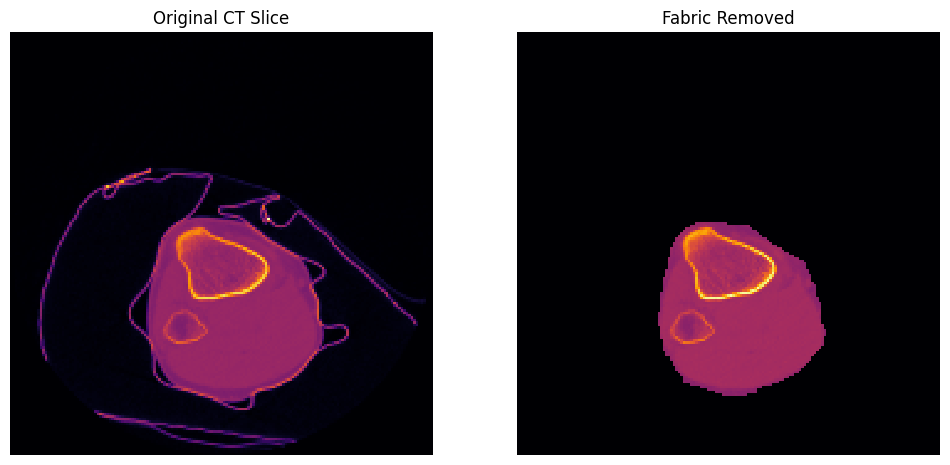

In [31]:
# Select a slice to visualize
cleaned_slice = cleaned_data[slice_index]

# Plot original vs cleaned
plot_comparison((slice_data, cleaned_slice), ("Original CT Slice", "Fabric Removed"))

In [32]:
# Define output filename
filename_out = "data/ct_scan_knee_preop_cleaned.nrrd"

# Save cleaned data with the original header
nrrd.write(filename_out, cleaned_data, header)

print(f"Cleaned CT scan saved to {filename_out}")

Cleaned CT scan saved to data/ct_scan_knee_preop_cleaned.nrrd
